In [107]:
import getpass
user_id = getpass.getuser()

import sys
sys.path.append(f"/home/{user_id}/OTTEHR/")

import matplotlib.pyplot as plt
from math import floor, ceil
from mimic_common import *
import numpy as np
import os
import pandas as pd
from scipy.stats import norm
import seaborn as sns
from statistics import median

In [108]:
def read_df(group_name, group_1, group_2, log=False, suffix = None):
    """ 
    Absoluate bound for filtering out ratios
    """
    target_equity_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{group_2}2{group_1}_equity.csv")
    if suffix is not None:
        target_equity_path = os.path.join(mimic_output_dir, f"exp4_{group_name}_{group_2}2{group_1}_{suffix}_equity.csv")
    target_equity_df = pd.read_csv(target_equity_path, header=0, index_col=None)
    target_labels = list(target_equity_df['target_label'])
    target_pred_labels = list(target_equity_df['target_pred_label'])
    if log:
        target_labels = [np.log(x) for x in target_labels]
        target_pred_labels = [np.log(x) for x in target_pred_labels]

    return target_labels, target_pred_labels

group_1 is: MARRIED, group_2 is: SINGLE
group_1 is: MARRIED, group_2 is: WIDOWED
group_1 is: MARRIED, group_2 is: DIVORCED
group_1 is: MARRIED, group_2 is: SEPARATED
group_1 is: SINGLE, group_2 is: MARRIED
group_1 is: SINGLE, group_2 is: WIDOWED
group_1 is: SINGLE, group_2 is: DIVORCED
group_1 is: SINGLE, group_2 is: SEPARATED
group_1 is: WIDOWED, group_2 is: MARRIED
group_1 is: WIDOWED, group_2 is: SINGLE
group_1 is: WIDOWED, group_2 is: DIVORCED
group_1 is: WIDOWED, group_2 is: SEPARATED
group_1 is: DIVORCED, group_2 is: MARRIED
group_1 is: DIVORCED, group_2 is: SINGLE
group_1 is: DIVORCED, group_2 is: WIDOWED
group_1 is: DIVORCED, group_2 is: SEPARATED
group_1 is: SEPARATED, group_2 is: MARRIED
group_1 is: SEPARATED, group_2 is: SINGLE
group_1 is: SEPARATED, group_2 is: WIDOWED
group_1 is: SEPARATED, group_2 is: DIVORCED


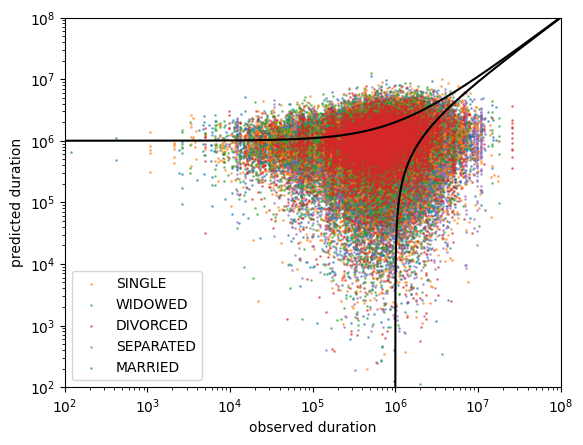

In [109]:
group_name = 'marital_status'
groups = ['MARRIED', 'SINGLE', 'WIDOWED', 'DIVORCED', 'SEPARATED']

# group_name = 'insurance'
# groups = ['Self_Pay', 'Private', 'Government', 'Medicare', 'Medicaid']
cmap = { 0:'k',1:'blue',2:'y',3:'g',4:'r' }

ax = plt.gca()
for i in range(len(groups)):
    for j in range(len(groups)): # for each pair of groups, we only consider it once
        if i == j:
            continue
        group_1 = groups[i]
        group_2 = groups[j]
        print(f"group_1 is: {group_1}, group_2 is: {group_2}")
        target_label, target_pred_label = read_df(group_name, group_1, group_2, log=False)
        ax.scatter(target_label, target_pred_label, s=1, alpha=0.5, color=f"C{j}", label=group_2)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('observed duration')
ax.set_ylabel('predicted duration')



#remove duplicates
handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)

plt.legend(newHandles, newLabels)
plt.ylim(10**2, 10**8)
plt.xlim(10**2, 10**8)


x = np.linspace(10**2, 10**8, 10**7)

y = x+10**6
plt.plot(x, y, c='black') # plot boundary to determine outliers

y = x-10**6
plt.plot(x, y, c='black') # plot boundary to determine outliers
plt.savefig(os.path.join(mimic_output_dir, f"{group_name}_target_duration_diff.pdf"), bbox_inches='tight')


[0.19410390077296422, 0.18996944094912818, 0.1803343519683624, 0.19543411828150278, 0.24015818802804242]


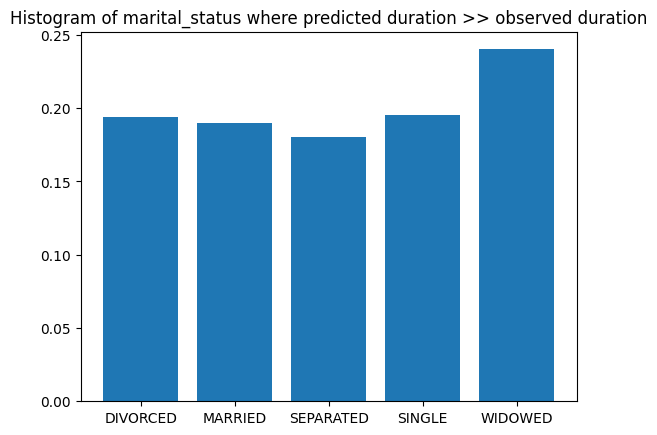

In [110]:
# Zoom in points that are outliers of the subset whose predicted duration >> observed duration 

thres = 10**6
plans = []
for i in range(len(groups)):
    for j in range(len(groups)): # for each pair of groups, we only consider it once
        if i == j:
            continue
        group_1 = groups[i]
        group_2 = groups[j]
        target_label, target_pred_label = read_df(group_name, group_1, group_2, log=False)
        for x, y in zip(target_label, target_pred_label):
            if y > x+thres  and y > 0:
                plans.append(group_2)

unique_values, counts = zip(*sorted(Counter(plans).items()))
counts = [x/sum(counts) for x in counts]
print(counts)
ret = plt.bar(unique_values, counts)
plt.title(f"Histogram of {group_name} where predicted duration >> observed duration")
plt.savefig(os.path.join(mimic_output_dir, f'{group_name}_longer_predicted_duration.pdf'), bbox_inches='tight')



[0.21256427730623878, 0.19788117217024967, 0.2256985316894864, 0.20661669041571154, 0.15723932841831362]


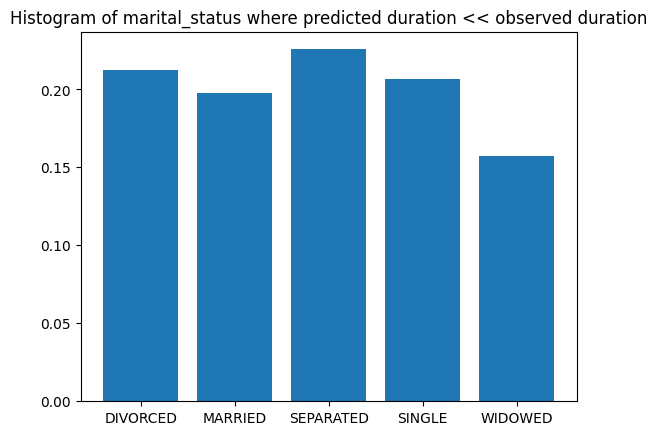

In [111]:
thres = 10**6
plans = []
for i in range(len(groups)):
    for j in range(len(groups)): # for each pair of groups, we only consider it once
        if i == j:
            continue
        group_1 = groups[i]
        group_2 = groups[j]
        target_label, target_pred_label = read_df(group_name, group_1, group_2, log=False)
        for x, y in zip(target_label, target_pred_label):
            if y < x-thres  and y > 0:
                plans.append(group_2)

unique_values, counts = zip(*sorted(Counter(plans).items()))
counts = [x/sum(counts) for x in counts]
print(counts)
plt.bar(unique_values, counts)
plt.title(f"Histogram of {group_name} where predicted duration << observed duration")
plt.savefig(os.path.join(mimic_output_dir, f'{group_name}_shorter_predicted_duration.pdf'), bbox_inches='tight')



group_1 is: MARRIED, group_2 is: SINGLE
group_1 is: MARRIED, group_2 is: WIDOWED
group_1 is: MARRIED, group_2 is: DIVORCED
group_1 is: MARRIED, group_2 is: SEPARATED
group_1 is: SINGLE, group_2 is: MARRIED
group_1 is: SINGLE, group_2 is: WIDOWED
group_1 is: SINGLE, group_2 is: DIVORCED
group_1 is: SINGLE, group_2 is: SEPARATED
group_1 is: WIDOWED, group_2 is: MARRIED
group_1 is: WIDOWED, group_2 is: SINGLE
group_1 is: WIDOWED, group_2 is: DIVORCED
group_1 is: WIDOWED, group_2 is: SEPARATED
group_1 is: DIVORCED, group_2 is: MARRIED
group_1 is: DIVORCED, group_2 is: SINGLE
group_1 is: DIVORCED, group_2 is: WIDOWED
group_1 is: DIVORCED, group_2 is: SEPARATED
group_1 is: SEPARATED, group_2 is: MARRIED
group_1 is: SEPARATED, group_2 is: SINGLE
group_1 is: SEPARATED, group_2 is: WIDOWED
group_1 is: SEPARATED, group_2 is: DIVORCED


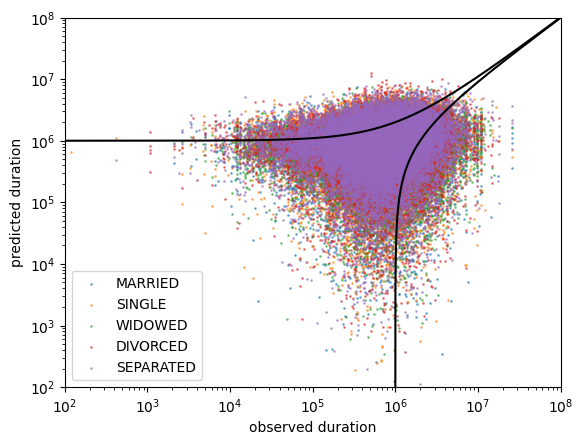

In [112]:
ax = plt.gca()
for i in range(len(groups)):
    for j in range(len(groups)): # for each pair of groups, we only consider it once
        if i == j:
            continue
        group_1 = groups[i]
        group_2 = groups[j]
        print(f"group_1 is: {group_1}, group_2 is: {group_2}")
        target_label, target_pred_label = read_df(group_name, group_1, group_2, log=False)
        ax.scatter(target_label, target_pred_label, s=1, alpha=0.5, color=f"C{i}", label=group_1)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('observed duration')
ax.set_ylabel('predicted duration')



#remove duplicates
handles, labels = plt.gca().get_legend_handles_labels()
newLabels, newHandles = [], []
for handle, label in zip(handles, labels):
    if label not in newLabels:
        newLabels.append(label)
        newHandles.append(handle)

plt.legend(newHandles, newLabels)
plt.ylim(10**2, 10**8)
plt.xlim(10**2, 10**8)


x = np.linspace(10**2, 10**8, 10**7)
# y = x
# plt.plot(x, y)

y = x+10**6
plt.plot(x, y, c='black')  
y = x-10**6
plt.plot(x, y, c='black')

plt.savefig(os.path.join(mimic_output_dir,f"{group_name}_source_duration_diff.pdf"), bbox_inches='tight')
